# Introduction to PyTorch


This notebook begins with an introduction to PyTorch, a very popular library in the field of deep learning.
We will take the neural network from the previous notebook and implement it in PyTorch.


In [2]:
import random
import numpy as np 
import matplotlib.pyplot as plt

# Import classiques des utilisateurs de pytorch 
import torch 
import torch.nn as nn
import torch.nn.functional as F

### Dataset and Dataloader


We will rebuild a dataset similar to the previous notebook. We also need to convert X and y into tensors (equivalent to Value in micrograd).


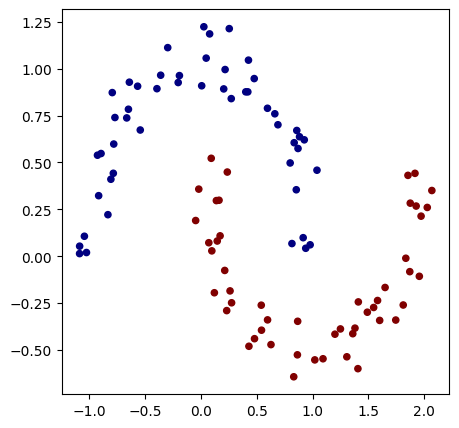

In [5]:
# Initialisation du dataset 
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.1)
X=torch.tensor(X).float() # Conversion en tensor pytorch (équivalent de Value)
y=torch.tensor(y).float() # Conversion en tensor pytorch
y = y*2 - 1 

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Now, let's use PyTorch features to create our dataset and dataloader.
The dataset simply groups the inputs and labels, while the dataloader simplifies the use of stochastic gradient descent by directly providing a random mini-batch of data from the dataset (the dataloader is an iterator).


In [6]:
from torch.utils.data import TensorDataset, DataLoader
# Création d'un dataset qui stocke les couples de valeurs X,y
dataset = TensorDataset(X, y)

# Création d'un dataloader qui permet de gérer automatiquement les mini-batchs pour la descente de gradient stochastique. 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

To learn more about the dataset and dataloader, you can consult the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).


### Model Construction


Now, let's build our model with 2 hidden layers.

To do this, we will create an MLP class that inherits from the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class.
Then, we build the network layers using the [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)(in_features, out_features) function, which creates a fully connected layer taking in_features as input and returning out_features as output.
This is a layer composed of out_features neurons connected to in_features inputs.


In [7]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(2,16) # première couche cachée 
    self.fc2=nn.Linear(16,16) # seconde couche cachée 
    self.fc3=nn.Linear(16,1) # couche de sortie
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [8]:
model = mlp() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Nombre de paramètres 337


We have the same number of parameters as in the previous notebook where we used micrograd.


### Loss Function


In PyTorch, some loss functions are already implemented in the library. Before implementing your own function, check if it already exists.

Here, we will use the PyTorch function torch.nn.MSELoss. This is the following loss:
$\text{MSE}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
where $y_i$ is the actual value (label), $\hat{y}_i$ is the predicted value, and $n$ is the total number of examples in the mini-batch.

In PyTorch, this loss function is easy to implement:


In [10]:
criterion=torch.nn.MSELoss()

### Training


For training, let's define the hyperparameters and the optimizer.
The [optimizer](https://pytorch.org/docs/stable/optim.html) is a PyTorch class that specifies the method for updating the weights during training (updating the model weights and learning rate). There are several optimizers: SGD, Adam, Adagrad, RMSProp, etc.
We use SGD (Stochastic Gradient Descent) to reproduce the training conditions of the previous notebook, but in practice, we often prefer to use Adam (Adaptive Moment Estimation).
To learn more about optimizers and their differences, you can consult the bonus course on optimizers, the [PyTorch documentation](https://pytorch.org/docs/stable/optim.html), or the [blog post](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/).


In [11]:
# Hyper-paramètres
epochs = 100 # Nombre de fois où l'on parcoure l'ensemble des données d'entraînement
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can also use a scheduler that changes the learning rate value during training. This can speed up convergence by starting with a high learning rate and gradually reducing it.
To have a learning rate that decreases during training, as in the micrograd example, we can use [LinearLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html#linearlr).
To learn more about the different types of schedulers, you can consult the [PyTorch documentation](https://pytorch.org/docs/stable/optim.html).


In [12]:
scheduler=torch.optim.lr_scheduler.LinearLR(optimizer=optimizer,start_factor=1,end_factor=0.05)

In [14]:
for i in range(epochs):
  loss_epoch=0
  accuracy=[]
  for batch_X, batch_y in dataloader:
    scores=model(batch_X)        
    loss=criterion(scores,batch_y.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step() # Pour activer le scheduler  
    loss_epoch+=loss
    
    accuracy += [(label > 0) == (scorei.data > 0) for label, scorei in zip(batch_y, scores)]
  accuracy=sum(accuracy) / len(accuracy) 
  
  if i % 10 == 0:
    print(f"step {i} loss {loss_epoch}, précision {accuracy*100}%")

step 0 loss 0.12318143993616104, précision tensor([100.])%
step 10 loss 0.1347985863685608, précision tensor([100.])%
step 20 loss 0.10458286106586456, précision tensor([100.])%
step 30 loss 0.14222581684589386, précision tensor([100.])%
step 40 loss 0.1081438660621643, précision tensor([100.])%
step 50 loss 0.10838648676872253, précision tensor([100.])%
step 60 loss 0.09485019743442535, précision tensor([100.])%
step 70 loss 0.07788567245006561, précision tensor([100.])%
step 80 loss 0.10796503722667694, précision tensor([100.])%
step 90 loss 0.07869727909564972, précision tensor([100.])%


Training is much faster!

We can visualize the results on our data:


(-1.6418534517288208, 2.108146548271179)

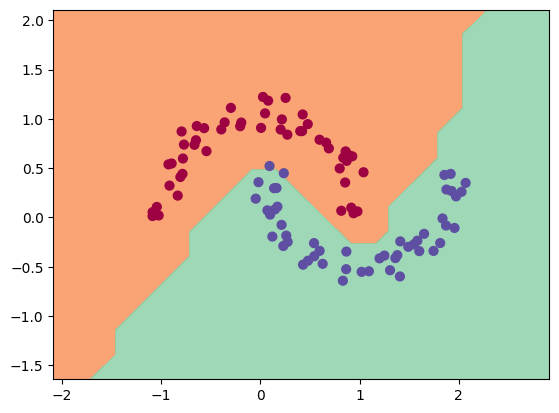

In [15]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs=torch.tensor(Xmesh).float()
scores=model(inputs)

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

As you can see, the training went well and we have a good separation of the data.
